In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from statistics import mode

In [2]:
def Gaus(e, e0=1.,sigma=0.3):
    return np.exp( -0.5*(e-e0)**2/sigma**2 )/np.sqrt( 2*np.pi*sigma**2 )

In [3]:
def Likelihood(mu,e,n,b,s):
    
    l = mu*s + e*b
    
    L = np.exp( -l ) * l**n / np.math.factorial(int(n))
    
    return L

In [4]:
def LogPrior(p):
    
    mu,e = p
    
    if mu >= 0. and e >= 0:
        return 0.
    else:
        return -np.inf

In [5]:
LogPrior([+0.1,+0.3])

0.0

In [6]:
def JointLogLikelihood(p,data,errors):
    
    N = data.shape[0]
    
    n = data[:,0]
    b = data[:,1]
    s = data[:,2]
    
    JointL = 0.
    
    mu, e = p
    
    for c in range(N):
        JointL += np.log(Likelihood(mu,e,n[c],b[c],s[c]))
        JointL += np.log(Gaus(e,sigma=errors[c]))
        
    return JointL

In [7]:
def LogPosterior(p,data,errors):
    
    LogP = LogPrior(p)
    
    if not np.isfinite(LogP):
        return -np.inf
    else:
        return JointLogLikelihood(p,data,errors) + LogP

In [8]:
n = np.array([3,8,8])
b = np.array([3,4,5])
s = np.array([1,3,3])

# Agregamos incertidumbre
errors = np.array([0.6,0.6,0.6])

N = n.shape[0]

data = np.zeros((N,3))

data[:,0] = n
data[:,1] = b
data[:,2] = s

print(data)
print(errors)

[[3. 3. 1.]
 [8. 4. 3.]
 [8. 5. 3.]]
[0.6 0.6 0.6]


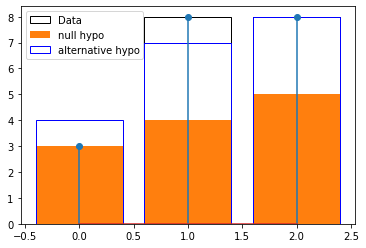

In [9]:
plt.bar(np.arange(0,N,1),n,ec='k',fill=False,label='Data')
plt.stem(n)
plt.bar(np.arange(0,N,1),b,label='null hypo')
plt.bar(np.arange(0,N,1),1*s+b,ec='b',color='b',fill=False,label='alternative hypo')
plt.legend(loc=0)

In [10]:
N = 50
mu = np.linspace(0.,4.,N)
e = np.linspace(0.,4.,N)
M,E = np.meshgrid(mu,e)
PosteriorMap = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        PosteriorMap[i,j] = LogPosterior([mu[i],e[j]],data,errors) 

/tmp/ipykernel_16831/1471885122.py:14: RuntimeWarning: divide by zero encountered in log
  JointL += np.log(Likelihood(mu,e,n[c],b[c],s[c]))


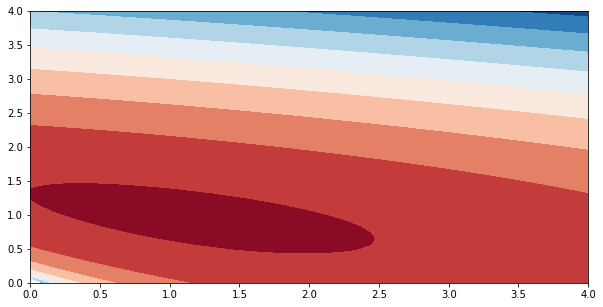

In [11]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.contourf(M,E,PosteriorMap.T,10,cmap='RdBu_r')

In [12]:
mu = np.linspace(0.001,3.,1000)
Posterior = np.zeros_like(mu)

for i in range(len(mu)):
    Posterior[i] = LogPosterior([mu[i],0.92],data,errors)

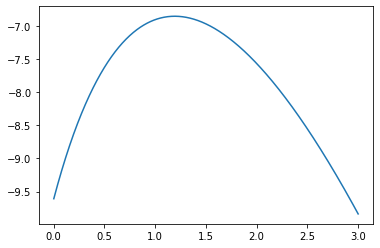

In [13]:
plt.plot(mu,Posterior)

In [14]:
ii = np.where( Posterior == np.amax(Posterior) )
muhat = mu[ii][0]
print(muhat)

1.1927947947947948


In [15]:
# Algoritmo de metropolis
n_walkers, n_params = 10,2
p0 = np.zeros((n_walkers,n_params))
p0[:,0] = 1
p0 += np.random.rand(n_walkers,n_params)
#p0

In [16]:
nll = lambda *p: LogPosterior(*p)
nll([0.2,0.4],data,errors)

-16.96413685003731

In [17]:
sampler = emcee.EnsembleSampler(n_walkers, n_params, nll, args=[data,errors])
pos,prob,state = sampler.run_mcmc(p0, 10000, progress = True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1829.08it/s]


Text(0.5, 0, 'step number')

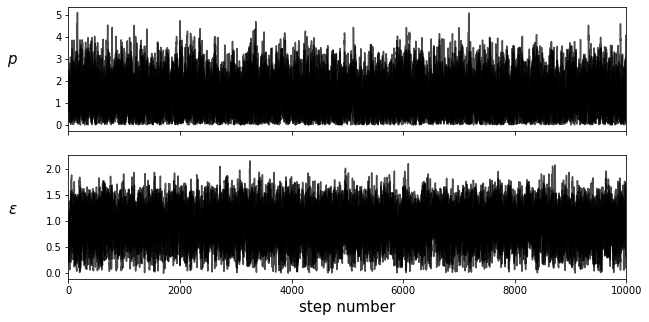

In [18]:
fig, axes = plt.subplots(n_params, figsize=(10, 5), sharex=True)

samples = sampler.get_chain()
labels = [r"$p$",r"$\epsilon$"]

for i in range(n_params):
    ax = axes[i]
    ax.plot(samples[:,:,i], "k", alpha=0.7)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0, fontsize=15)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number",fontsize=15)

In [19]:
flat_samples = sampler.get_chain(discard=500, thin=20, flat=True)
truths = np.percentile(flat_samples, 50, axis=0)
truths

array([1.29418091, 0.93675913])

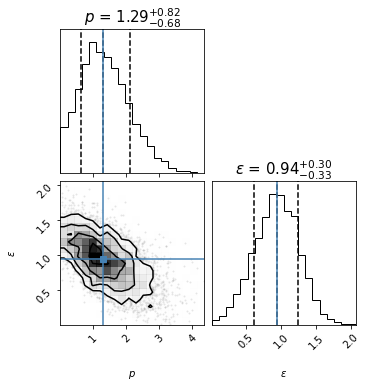

In [20]:
figure = corner.corner(flat_samples, 
                       truths=truths, 
                       labels=labels, 
                       quantiles=[0.16,0.5,0.84], 
                       show_titles=True,
                       title_kwargs={"fontsize":15})

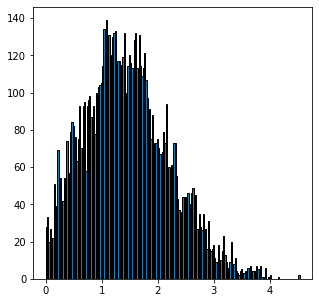

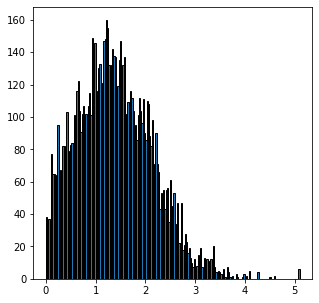

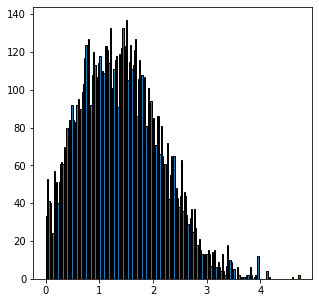

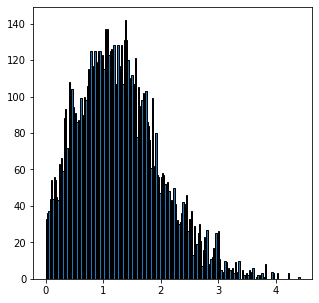

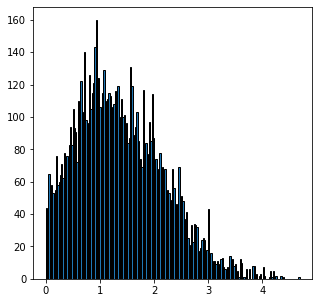

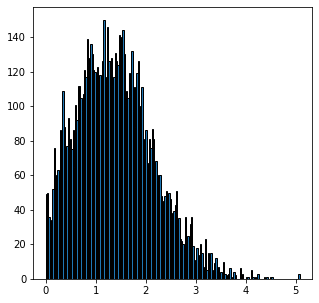

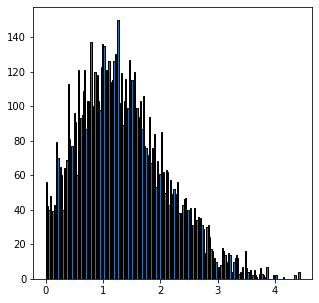

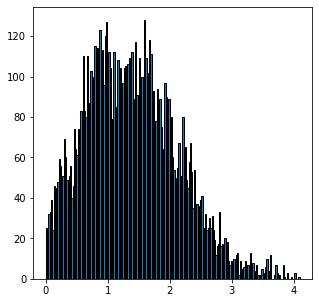

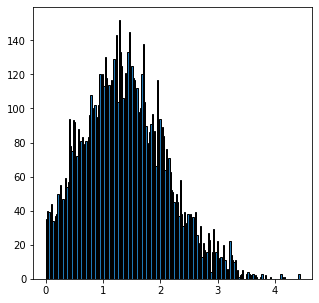

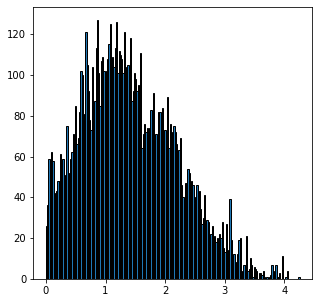

In [21]:
Modas = np.array([])
UpperLimits = np.array([])

for j in range(n_walkers):
    lista = samples[:,:,0][:,j]
    
    x = np.linspace(np.min(lista),np.max(lista),200)
    H,bins = np.histogram(lista,bins=x)
    w = np.diff(bins)
    
    #print(H)
    fig = plt.figure(figsize=(5,5))
    plt.bar(bins[:-1]+0.5*w[0],H,width=w,ec='k')
    
    # Intervalo de mayor frecuencia
    ii = np.where( H == np.amax(H) )
    i = ii[0][0]
    
    
    Li = bins[i]
    
    Moda = Li + w[0]*(  (H[i]-H[i-1])/(  (H[i]-H[i-1]) + (H[i]-H[i+1])  )   )
  #  print(Moda)
    Modas = np.append(Modas,Moda)
    UpperLimits = np.append(UpperLimits, np.percentile(lista,95))

In [22]:
Modas

array([1.0807347 , 1.22222541, 1.50556817, 1.38537284, 0.92739212,
       1.15965629, 1.25737359, 1.59930769, 1.28426676, 0.86263059])

In [23]:
UpperLimits

array([2.78961977, 2.65655966, 2.69674432, 2.5747195 , 2.79441085,
       2.7333879 , 2.72549279, 2.66942813, 2.64975591, 2.81996045])

In [24]:
np.mean(Modas)

1.228452816672779

In [25]:
np.mean(UpperLimits)

2.7110079277489083